## Constant from IV-characteristics : <font color = 'sky blue'> $n_e, T_e, T_-, I_{sat+}$ </font>
<font size="2">
    [1] <a href="https://sci-hub.se/https://aip.scitation.org/doi/10.1063/1.4802252"> [2013] Langmuir probe analysis of highly electronegative plasmas</a> <br>
    [2] <a href="https://sci-hub.se/https://doi.org/10.1063/1.4903328"> [2014] Langmuir probe analysis in electronegative plasmas</a> <br>
    [3] <a href="https://sci-hub.se/https://doi.org/10.1063/1.874162"> [2000] How big is a small Langmuir probe?</a> <br>
    [4] <a href="https://sci-hub.se/10.1088/0022-3727/43/10/105204"> [2010] The plasma sheath around large discs and ion collection by planar Langmuir probes</a> <br>

In [157]:
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import importlib

from scipy.optimize import fsolve
from scipy.integrate import simpson
from scipy.integrate import odeint

from const import *
import ldf
import plotting
import method

importlib.reload(plotting)
importlib.reload(ldf)
importlib.reload(method)

<module 'method' from 'c:\\Users\\GUNU\\OneDrive\\바탕 화면\\negative-ion\\method.py'>

./211221(SF6)/SF6/Radial Scan_15sccm/0.ldf
no eedf datas


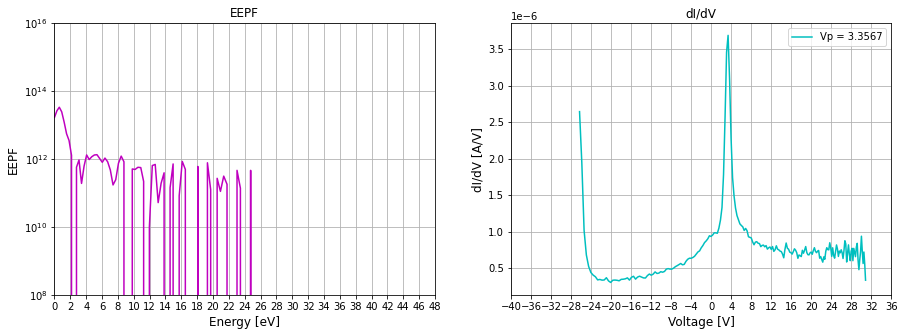

Enter limited energy
ne: 3.389e+13 [m-3]	 Te: 0.951 [eV] 	 V_lim: 2.0
a_0: 3.0000	 a_s: 1.4928	 gamma: 9.5098	 sol_number: 1
J: 5.57e+00	 uB: 343.053	 r_sh: 3.41e-04	
-------------------------------------------------------
a_0: 4988.5609	 a_s: 3188.6554	 gamma: 9.5098	 sol_number: 1
J: 1.63e+00	 uB: 274.701	 r_sh: 4.92e-04	
-------------------------------------------------------
a_0: 1825.9867	 a_s: 1166.9049	 gamma: 9.5098	 sol_number: 1
J: 1.13e+00	 uB: 274.768	 r_sh: 5.54e-04	
-------------------------------------------------------
a_0: 1266.3341	 a_s: 809.1337	 gamma: 9.5098	 sol_number: 1
J: 1.01e+00	 uB: 274.815	 r_sh: 5.77e-04	
-------------------------------------------------------
a_0: 1123.0844	 a_s: 717.5579	 gamma: 9.5098	 sol_number: 1
J: 9.66e-01	 uB: 274.834	 r_sh: 5.84e-04	
-------------------------------------------------------
a_0: 1078.9736	 a_s: 689.359	 gamma: 9.5098	 sol_number: 1
J: 9.53e-01	 uB: 274.841	 r_sh: 5.87e-04	
------------------------------------------

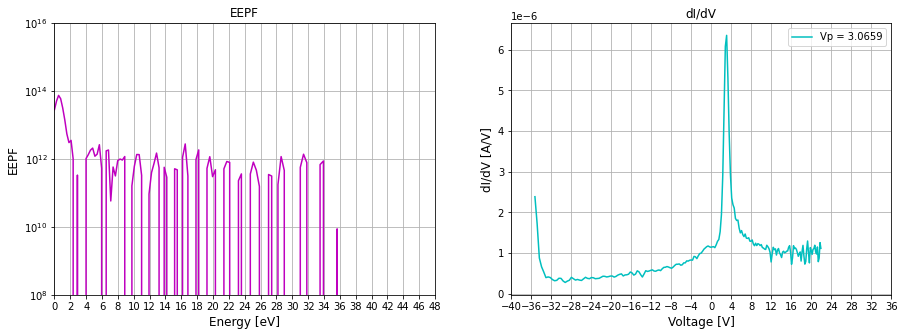

Enter limited energy


ValueError: could not convert string to float: ''

In [158]:
data_iter, data_fit = [], []

#workDir = './211216(SF6)/bias (float) 0mm B-field/'
workDir = './211221(SF6)/SF6/Radial Scan_15sccm/'
parser = ldf.parser(workDir)
ldf_list = parser.ldf_paths()

for file in ldf_list:

    # Check file name
    print(file)


    # Parsing IV curve from ldf file
    IV, imported_eedf, result = parser.pull_attr(file, need_return=True)
    x = float(file.split('/')[-1][:-4])


    # Calculation x, Vsat, Isat, Vp, eepf, eedf, second_derivative from IV curve
    processor = ldf.processor(IV)
    Vsat, Isat = processor.cal_sat()
    Vp = processor.cal_Vp()
    energy, eepf, eedf = processor.cal_eepf()
    V, IV_second_derivative = processor.cal_second_derivative()


    # Plot EEPF and dIdV to determine energy range 
    plotting.plot_check(energy, eepf, processor.V, processor.dIdV, Vp)


    # Enter energy range for EEDF integration to get ne & Te
    print("Enter limited energy")
    V_lim = input()
    V_lim = np.float32(V_lim)


    # Calculation ne & Te from EEDF
    ne = processor.cal_ne(V_lim)
    Te = processor.cal_Te(ne, V_lim)
    print('ne: {:.3e} [m-3]\t Te: {:.3f} [eV] \t V_lim: {}'.format(ne, Te, V_lim))
    

    # Start Iterative method
    iter_1 = method.iterative(ne, Te, Vsat, Isat, Vp)
    alpha_iter = iter_1.iteration()
    nm = ne*alpha_iter
    #print("Iteration method \tVp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    data_iter.append((Vp, alpha_iter, Te, x, ne, nm))


    # Start Fitting method
    # fit_1 = method.fitting(IV, V, IV_second_derivative)
    # alpha_fit = fit_1.fitting()
    # nm = ne*alpha_fit
    # #print("Fitting method \tVp: {}, Vsat: {}, Isat: {}\n\n".format(Vp, Vsat, Isat))
    # data_fit.append((Vp, alpha_fit, Te, x, ne, nm))


# Plot results
df_iter = pd.DataFrame(data_iter, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])
plotting.plot_default(df_iter['x'], df_iter['Te'], df_iter['Vp'], df_iter['alpha'], df_iter['ne'])
plotting.plot_density(df_iter['x'], df_iter['ne'], df_iter['nm'])

# df_fit = pd.DataFrame(data_fit, columns=['Vp', 'alpha', 'Te', 'x', 'ne', 'nm'])
# plotting.plot_default(df_fit['x'], df_fit['Te'], df_fit['Vp'], df_fit['alpha'], df_fit['ne'])
# plotting.plot_density(df_fit['x'], df_fit['ne'], df_fit['nm'])

0.05754026132188865


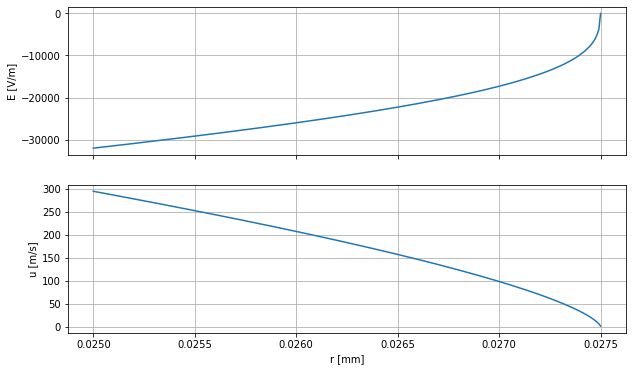

In [143]:
rp= 25e-6
J = 10
uB = 1
s = 0.1*25e-6

def cylindrical_sheath(s):
    R = rp + s
    r_list = np.linspace(R, rp, 300)
    def fun(y, r):
        return [R*J/(r*epsilon_0*y[1]) - y[0]/r, e*y[0]/(Mp*y[1])]

    sol = odeint(fun, y0=[0, uB], t=r_list)
    V = simpson(sol[:, 0], r_list)
    return sol[:, 0], sol[:, 1], V, r_list

def child_law(s):
    V = (9/4/epsilon_0*J*s**2*np.sqrt(Mp/2/e))**(2/3)
    return V

E, u, V, r_list = cylindrical_sheath(s)

plt.subplots(figsize=(10,6))
ax1 = plt.subplot(2,1,1)
plt.plot(r_list*1e3, E)
plt.ylabel('E [V/m]')
plt.xticks(visible=False)
plt.grid(True)

ax2 = plt.subplot(2,1,2,sharex=ax1)
plt.plot(r_list*1e3, u)
plt.ylabel('u [m/s]')
plt.xlabel('r [mm]')
plt.grid(True)
print(V)

In [146]:
s_list = np.linspace(0.01*rp, 10*rp, 200)
V_list = []
V_child_list = []

for s in s_list:
    V_list.append(cylindrical_sheath(s)[2])
    V_child_list.append(child_law(s))

V_list = np.array(V_list)
V_child_list = np.array(V_child_list)

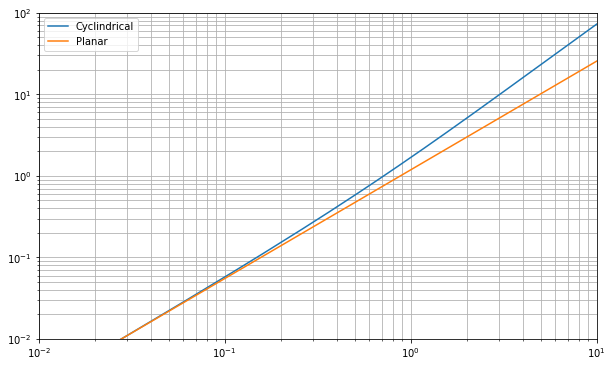

In [147]:
plt.figure(figsize=(10,6))
plt.plot((s_list)/rp, V_list)
plt.plot((s_list)/rp, V_child_list)

plt.legend(['Cyclindrical', 'Planar'])
plt.xscale('log')
plt.yscale('log')
plt.xticks()
plt.xlim(1e-2,1e1)
plt.ylim(1e-2,1e2)
plt.grid(True, 'both')